<center><img src="img/Marca-ITBA-Color-ALTA.png" width="250">

<h1>Master en Management & Analytics</h1>
</center>


## Clase 4- Sesgo y varianza. Regularización

#### Referencias y bibliografía de consulta:

- Introduction to Machine Learning with Python by Andreas C. Müller and Sarah Guido (O’Reilly) 2017 - capítulos 1 y 2
- An Introduction to Statistical Learning with Applications in R by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani (Springer) 2017 - capítulos 2 y 3
- Python Machine Learning - Second Edition by Sebastian Raschka (Packt) 2017 - capítulo 1
- Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems - Aurélien Géron - 2017
- https://scikit-learn.org/


### 1) Trade-off entre sesgo y varianza

Realicemos un repaso sobre los conceptos de sesgo y varianza, recordando el siguiente gráfico:

<img src="img/model_compl.png" width="750">
<div class='epigraph' align="center"><i>MSE en función de los grados del polinomio</i></div><br>

- En el primer caso, donde el grado del polinomio es 1, el modelo es demasiado simple (tiene pocos grados de libertad). Por lo tanto, no importa cuán grande sea el dataset: tenemos **sesgo o error sistemático**, también denominado **underfitting**.

- En el tercer caso, donde el grado del polinómio es 15, el modelo es demasiado complejo (ie. tiene demasiados grados de libertad), entonces el estimador puede ajustarse a variaciones espurias de la muestra generando un  **sobre-ajuste** u **overfitting**

- El objetivo, por lo tanto es encontrar un **balance óptimo** entre la complejidad del modelo y nuestros datos. Aquí radica el mayor desafío de un proyecto de machine learning.

<img src="img/underfvsoverf.png" width="450">
<div class='epigraph' align="center"><i>Error en función de la complejidad del modelo</i></div><br>

Para **resolver un problema de underfitting**, tenemos que incrementar su poder de ajuste. Esto puede hacerse de varias maneras. Por ejemplo: 

- Utilizar un modelo más potente (en el módulo de modelos avanzados vamos a ver varios modelos de machine learning)
- Enquiquecer nuestro dataset con más variables
- Realizar tareas de *feature engineering* sobre las variables que tenemos, como por ejemplo generar variables polinómicas.


##### Exploremos ahora estos conceptos volviendo a nuestro dataset sobre el precio de las casas de King County:

<img src="img/House sale.jpg" width="400"  >

En la clase de hoy vamos a seguir trabajando con el [dataset](https://geodacenter.github.io/data-and-lab/KingCounty-HouseSales2015/) de precios de venta de viviendas del King County. 

Recordemos cuáles son los atributos del dataset y qué representa cada uno:
Tenemos 21 atributos:
- **id**: identificación
- **date**: fecha de venta       
- **price**: precio de venta. Esta es nuestra `variable objetivo`.
- **bedrooms**: cantidad de habitaciones
- **bathrooms**: cantidad de baños
- **sqft_living**: tamaño de la zona habitable en pies cuadrados
- **sqft_lot**: tamaño del lote en pies cuadrados
- **floors**: cantidad de pisos
- **waterfront**: 1 si la propiedad tiene un frente de agua, 0 si no.
- **view**: un índice de 0 a 4 de lo buena que era la vista de la propiedad
- **condition**: estado de la casa, clasificado del 1 al 5
- **grade**: clasificación según la calidad de la construcción, que se refiere a los tipos de materiales utilizados y a la calidad de la mano de obra. Los edificios de mejor calidad (mayor grado) cuestan más de construir por unidad de medida y tienen mayor valor.
- **sqft_above**: Pies cuadrados sobre el suelo
- **sqft_basement**: Pies cuadrados bajo tierra
- **yr_built**: año de construcción
- **yr_renovated**: año de renovación. 0 si no se ha renovado nunca
- **zipcode**: código postal de 5 dígitos
- **lat**: latitud
- **long**: longitud
- **sqft_living15**: tamaño medio del espacio habitable de las 15 casas más cercanas, en pies cuadrados
- **sqft_lot15**: tamaño medio del lote de las 15 casas más cercanas, en pies cuadrados

Vamos a comenzar, como de costumbre importando algunas de las librerías que vamos a necesitar:

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

Creamos un DataFrame tomando el csv con los datos:

In [2]:
dataset = pd.read_csv('data/kc_house_data.csv')

dataset.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Vamos a realizar las tareas de limpieza que hicimos la clase pasada:

In [3]:
# Casteamos el atributo 'date' a datetime
dataset['date'] = pd.to_datetime(dataset['date'])

# Creamos una variable que represente el año de venta
dataset['year_sold'] = dataset['date'].dt.year

# Corregimos el error de carga en 'bedrooms'
dataset.loc[dataset['bedrooms']==33,'bedrooms'] = 3

Creamos nuestra matriz de features y nuestro vector target.

In [4]:
# Creamos X e y
features_cols = [x for x in dataset.columns if x not in ['price','id', 'date','zipcode']]
X = dataset[features_cols]
y = dataset['price']

# Verificamos el shape y el tipo de X e y:
print("Shape X:", X.shape)
print("Type X:", type(X))
print("Shape y:", y.shape)
print("Type y:", type(y))

Shape X: (21613, 18)
Type X: <class 'pandas.core.frame.DataFrame'>
Shape y: (21613,)
Type y: <class 'pandas.core.series.Series'>


In [5]:
X.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year_sold'],
      dtype='object')

Hacemos el split entre train y test sets:

In [6]:
rs=1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

Realizamos la imputación de las variables 'bedrooms' y 'bathrooms' para las casas con valores igual a 0, cuidando de calcular los valores en el set de entrenamiento y utilizando dichos valores para el train y test sets:

In [7]:
X_train['bedrooms'].replace(0, np.nan, inplace=True)
X_train['bathrooms'].replace(0, np.nan, inplace=True)
X_test['bedrooms'].replace(0, np.nan, inplace=True)
X_test['bathrooms'].replace(0, np.nan, inplace=True)

X_train.fillna(X_train.groupby('floors').transform('median'), inplace=True)

dicc_bed = X_train.groupby('floors')['bedrooms'].median().apply(np.ceil).to_dict()
dicc_bath = X_train.groupby('floors')['bathrooms'].median().apply(np.ceil).to_dict()

X_test['bedrooms'] = X_test['bedrooms']\
                            .fillna(X_test['floors'].apply(lambda x: dicc_bed.get(x)))

X_test['bathrooms'] = X_test['bathrooms']\
                            .fillna(X_test['floors'].apply(lambda x: dicc_bath.get(x)))

#### 1.1) Estandarización

Un aspecto metodológico importante es que para aplicar estas técnicas de regularización, tenemos que normalizar los datos. Esto se debe a que, al penalizar los parámentros por su tamaño, la escala en la que están medidas las variables se vuelve absolutamente relevante.

Con el modelo de regresión lineal sin regularización, el valor de los parámetros compensaba por las unidades de medida de las variables, por lo que no afectaba al resultado del modelo. Al aplicar regularización, no queremos que efectos de escala afecten la imporancia relativa de los parámetros. Por este motivo, estandarizamos a todas las variables, con media $0$ y desvío estándar $1$, de modo tal que de llevar a todas las variables a una escala común. 

Uno de los aspectos que tenemos que saber antes de entrenar un modelo de machine learning es si requiere o no que los datos estén normalizados.

Apliquemos estandarización, transformando las variables para que tengan media 0 $(\mu = 0)$ y desvío estándar 1 $(\sigma = 1)$, aplicando la fórmula:

$$ x' = \frac{x - \mu}{\sigma}$$

In [8]:
from sklearn.preprocessing import StandardScaler

stdscaler = StandardScaler()

X_train_std = pd.DataFrame(stdscaler.fit_transform(X_train), columns=X_train.columns)

X_test_std = pd.DataFrame(stdscaler.transform(X_test), columns=X_test.columns)

Corroboremos que el scaler almacena la media y el desvío estándar de X_train:

In [9]:
stdscaler.mean_

array([ 3.36856369e+00,  2.11710952e+00,  2.07828587e+03,  1.52178878e+04,
        1.49811620e+00,  7.66739375e-03,  2.31674268e-01,  3.41013947e+00,
        7.66038734e+00,  1.78580144e+03,  2.92484434e+02,  1.97110285e+03,
        8.40272325e+01,  4.75591187e+01, -1.22213391e+02,  1.98409690e+03,
        1.27788480e+04,  2.01432580e+03])

In [10]:
X_train.mean(axis=0).values

array([ 3.36856369e+00,  2.11710952e+00,  2.07828587e+03,  1.52178878e+04,
        1.49811620e+00,  7.66739375e-03,  2.31674268e-01,  3.41013947e+00,
        7.66038734e+00,  1.78580144e+03,  2.92484434e+02,  1.97110285e+03,
        8.40272325e+01,  4.75591187e+01, -1.22213391e+02,  1.98409690e+03,
        1.27788480e+04,  2.01432580e+03])

In [11]:
stdscaler.scale_

array([9.01775516e-01, 7.62054673e-01, 9.03225256e+02, 4.32894492e+04,
       5.41166470e-01, 8.72273169e-02, 7.62971710e-01, 6.51730594e-01,
       1.16782244e+00, 8.17312381e+02, 4.40352527e+02, 2.94149217e+01,
       4.00800643e+02, 1.38806082e-01, 1.40607580e-01, 6.79357867e+02,
       2.78058207e+04, 4.68672285e-01])

In [12]:
X_train.std(axis=0).values

array([9.01805320e-01, 7.62079860e-01, 9.03255108e+02, 4.32908799e+04,
       5.41184356e-01, 8.72301999e-02, 7.62996927e-01, 6.51752134e-01,
       1.16786104e+00, 8.17339394e+02, 4.40367081e+02, 2.94158939e+01,
       4.00813890e+02, 1.38810670e-01, 1.40612227e-01, 6.79380321e+02,
       2.78067397e+04, 4.68687775e-01])

Es importante notar que estamos haciendo el `fit_transform()` de `stdscaler` con los datos de entrenamiento. Para los datos de testeo, estamos usando el método `transform`, es decir que normalizamos utilizando las medias y desvíos estándar calculados en el set de entrenamiento. Esto es así para evitar **data leakage**, es decir filtración de información del set de testo en el modelo.  

Corroboremos los valores de la media y el desvío estándar:

In [13]:
X_train_std.mean(axis=0).round(2)

bedrooms         0.0
bathrooms        0.0
sqft_living      0.0
sqft_lot         0.0
floors          -0.0
waterfront       0.0
view            -0.0
condition       -0.0
grade            0.0
sqft_above      -0.0
sqft_basement   -0.0
yr_built         0.0
yr_renovated     0.0
lat              0.0
long             0.0
sqft_living15   -0.0
sqft_lot15       0.0
year_sold       -0.0
dtype: float64

In [14]:
X_train_std.std(axis=0)

bedrooms         1.000033
bathrooms        1.000033
sqft_living      1.000033
sqft_lot         1.000033
floors           1.000033
waterfront       1.000033
view             1.000033
condition        1.000033
grade            1.000033
sqft_above       1.000033
sqft_basement    1.000033
yr_built         1.000033
yr_renovated     1.000033
lat              1.000033
long             1.000033
sqft_living15    1.000033
sqft_lot15       1.000033
year_sold        1.000033
dtype: float64

#### 1.2)  Regresión lineal múltiple sin regularización

Volvamos a entrenar el modelo de regresión lineal múltiple para tener de referencia:

In [15]:
model_mult = LinearRegression(fit_intercept=True)
model_mult

model_mult.fit(X_train_std, y_train)

y_pred_train = model_mult.predict(X_train_std)
y_pred_test = model_mult.predict(X_test_std)

print ('R2 train sin regularizacion: {}'.format(r2_score(y_train, y_pred_train).round(4)))
print ('R2 test sin regularizacion: {}'.format(r2_score(y_test, y_pred_test).round(4)))

R2 train sin regularizacion: 0.7018
R2 test sin regularizacion: 0.6878


Se puede apreciar que haber normalizado los datos no afecta la performance del modelo.

Vemos que el modelo presenta una bondad de ajuste similar en el set de entrenamiento y de testeo.

Vamos a darle más poder de ajuste al modelo agregando *features* polinómicas. Veamos qué pasa con el modelo a medida que agregamos variables polinómicas de grado mayor

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

Para que se pueda apreciar mejor el efecto de las variables polinómicas, vamos a quedarnos solamente con las variables más importantes.

No va a cambiar la esencia de lo que queremos ver y el overfitting se a a poder apreciar más gradualmente.

In [17]:
X_train_poly = X_train_std[['sqft_living', 'grade', 'sqft_above', \
                            'sqft_living15', 'bathrooms', 'view', 'sqft_basement',\
                           'bedrooms', 'lat', 'waterfront', 'floors']]

X_test_poly = X_test_std[['sqft_living', 'grade', 'sqft_above', \
                            'sqft_living15', 'bathrooms', 'view', 'sqft_basement',\
                           'bedrooms', 'lat', 'waterfront', 'floors']]

In [18]:
train_scores = []
test_scores = []

max_deg = 5

for deg in range(1, max_deg):
    model = PolynomialRegression(degree=deg).fit(X_train_poly, y_train)
    y_pred_train = model.predict(X_train_poly)
    y_pred_test = model.predict(X_test_poly)
    train_scores.append(r2_score(y_train, y_pred_train))
    test_scores.append(r2_score(y_test, y_pred_test))

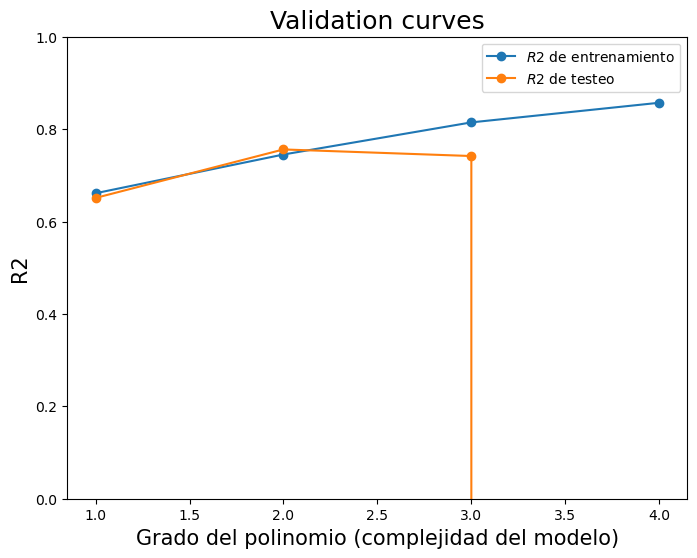

In [19]:
plt.figure(figsize=(8,6))
plt.plot(list(range(1,max_deg)),train_scores, '-o')
plt.plot(list(range(1,max_deg)),test_scores, '-o')
plt.ylim([0,1])
plt.legend(['$R2$ de entrenamiento', '$R2$ de testeo'])
plt.title('Validation curves',fontdict=dict(fontsize=18))
plt.xlabel('Grado del polinomio (complejidad del modelo)', fontdict=dict(fontsize=15))
plt.ylabel('R2', fontdict=dict(fontsize=15));

Vemos que en un principio, ambos $R2$ crecen juntos. A partir del grado 3 el modelo empieza a sobreajustar el set de entrenamiento. Desde el grado 4, el overfitting es tan alto que el $R2$ colapsa. 

#### 1.3) Learning curves

Si tenemos un **problema de overfitting**, una opción válida es incrementar el tamaño del dataset, ya que, a igualdad de complejidad de un modelo, a mayor tamaño del dataset tendremos menos **varianza**. 

<img src="img/errorvsdatasize.png" width="450">
<div class='epigraph' align="center"><i>Error en relación al tamaño del dataset</i></div><br>

Probemos esto en nuestro dataset:

In [20]:
train_errors = []
val_errors = []

model = LinearRegression(fit_intercept=True)

for m in range(1, len(X_train_std), 100):
    model.fit(X_train_std[:m], y_train[:m])
    y_pred_train = model.predict(X_train_std[:m])
    y_pred_test = model.predict(X_test_std)
    train_errors.append(mean_squared_error(y_train[:m], y_pred_train))
    val_errors.append(mean_squared_error(y_test, y_pred_test))

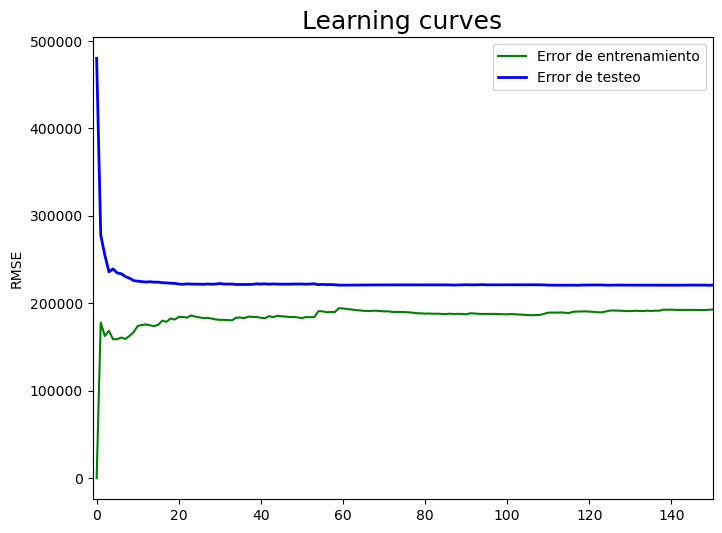

In [21]:
plt.figure(figsize=(8,6))
plt.plot(np.sqrt(train_errors), "g", linewidth=1.5)
plt.plot(np.sqrt(val_errors), "b", linewidth=2)
plt.xlim([-1,150])
plt.legend(['Error de entrenamiento', 'Error de testeo'])
plt.title('Learning curves',fontdict=dict(fontsize=18))
plt.ylabel('RMSE');

Otra forma de lidiar con un problema de **overfitting** es aplicar alguna técnica de **regularización**.

### 2) Regularización

Hasta ahora, cuando ajustamos modelos lineales, seleccionamos el modelo que minimizaba el error cuadrático.

Para un modelo de la forma


$$\text{y=X}w+ \epsilon$$

minimizamos la suma
$$\sum_{i}{\left(\hat{y}_i - y_i \right)^2}$$

Este es un ejemplo de **funcion de costo**: una función que mide el "costo" de los errores de las predicciones de un modelo. Para aplicar la técnica de regularización, modificamos la función de costo, agregando un término que penaliza los modelos por su complejidad. Por ejemplo, podríamos tener una nueva función de costo de la forma:

$$\sum_{i}{\left(\hat{y}_i - y_i \right)^2 + \alpha f(w)}$$

donde $f(w)$ es una función de los parámetros de nuestro modelo y $\alpha$ es un hiperparámetro que controla cuán fuerte es la penalización.

Un mayor valor de $\alpha$ significa una mayor penalización, ya que aumenta el costo, que es lo que buscamos minimizar. Esto conllevará a **valores más chicos de los parámetros estimados**. 

En esta práctica, veremos 3 ejemplos de regularización:

- **Regresión Ridge**
- **Regresión Lasso**
- **ElasticNet**

Conceptualmente, todas son iguales: buscan reducir el tamaño de los parámetros agregando una penalidad. Lo que cambia entre las diferentes técnicas es la forma de $f(w)$:


###### Regresión Ridge

$$\sum_{i}{\left(\hat{y}_i - y_i \right)^2} + \alpha \sum_{j}{{w}_j}^2$$


A medida que incrementamos $\alpha$, los parámentros $w_j$ van a tender asintóticamente a cero.

A esta penalidad se la conoce también como *L2*. 

Podemos verlo en el siguiente gráfico tomado de "An Introduction to Statistical Learning with Applications in R" de Gareth James et al. Tengamos en cuenta que al *hiperparámetro* $\alpha$, también suele llamárselo $\lambda$.

<img src="img/ridge.png" width="350">


###### Regresión Lasso

$$\sum_{i}{\left(\hat{y}_i - y_i \right)^2} + \alpha \sum_{j}|{{{w}_j}|}$$

En el caso de **Lasso**, al incrementarse $\alpha$, los parámetros van convirtiéndose en $0$. Por este motivo, se dice que **Lasso** es además una técnica de **feature selection**. 

A esta penalidad se la conoce también como *L1*. 

Veamos el ejemplo anterior pero con regularización Lasso:

<img src="img/lasso.png" width="350">


Se puede demostrar que los coeficientes estimados por Ridge y Lasso resuelven los siguientes problemas de minimización con restricciones:

**Ridge**
$$ min_{{w}} {\sum_{i}{\left(\hat{y}_i - y_i \right)^2}}\quad sujeto \quad  a \quad  \sum_{j}{{w}_j}^2 \leq s$$

**Lasso**
$$ min_{{w}} {\sum_{i}{\left(\hat{y}_i - y_i \right)^2}}\quad sujeto \quad  a \quad  \sum_{j}|{{{w}_j}|} \leq s$$

Donde a mayor valor de $\lambda$ el valor de $s$ es más chico.

Veamos el siguiente gráfico para obtener una intuición de la diferencia entre ambas regularizaciones. Hay que tener en cuenta que en el gráfico, los pesos que nosotros indicamos con $w$, están indicados con $\beta$.


<img src="img/ridgevslasso.png" width="500">

Las regularizaciones pueden pensarse como “restricciones presupuestarias” a los posibles valores de $w$. Lasso es más propenso a generar soluciones en las que alguno de los coeficientes es exactamente cero.

###### ElasticNet

- Combina linealmente las regularizaciones de Ridge y Lasso. Cuando entrenemos el modelo, vamos a ver cómo `Sklearn` implementa la combinación. 
- Es posible obtener soluciones parsimoniosas y bien condicionadas. 
- Ahora tenemos que optimizar 2 hiperparámetros: no free lunch!


#### 2.1) Modelo base sin regularización

Vamos a crear un modelo base sin regularización. Para poder apreciar el efecto de la regularización, este modelo debería tener un problema de overfitting. Vamos a tomar nuestra regresión lineal y vamos a crear variables polinómicas para un subset de las $features$, con el objetivo de llegar a tener un problema de sobreajuste que podamos mitigar con las técnicas de regularización que estamos estudiando. 

In [22]:
X_train_pol = PolynomialFeatures(degree=3, include_bias=False).fit_transform(\
                      X_train_std[['sqft_living', 'grade', 'sqft_above','sqft_living15',\
                                  'bathrooms', 'view', 'sqft_basement', 'bedrooms']])

X_train_no_pol = X_train_std[[x for x in X_train_std.columns if x not in ['sqft_living', \
                                 'grade', 'sqft_above','sqft_living15',\
                                  'bathrooms', 'view', 'sqft_basement', 'bedrooms']]].values

X_train_feat_eng = np.concatenate((X_train_pol, X_train_no_pol), axis=1 )


print('X_train_pol.shape: {}'.format(X_train_pol.shape))
print('X_train_no_pol.shape: {}'.format(X_train_no_pol.shape))
print('X_train_feat_eng.shape: {}'.format(X_train_feat_eng.shape))

X_train_pol.shape: (15129, 164)
X_train_no_pol.shape: (15129, 10)
X_train_feat_eng.shape: (15129, 174)


In [23]:
X_test_pol = PolynomialFeatures(degree=3, include_bias=False).fit_transform(\
                      X_test_std[['sqft_living', 'grade', 'sqft_above','sqft_living15',\
                                  'bathrooms', 'view', 'sqft_basement', 'bedrooms']])

X_test_no_pol = X_test_std[[x for x in X_train_std.columns if x not in ['sqft_living', \
                                 'grade', 'sqft_above','sqft_living15',\
                                  'bathrooms', 'view', 'sqft_basement', 'bedrooms']]].values

X_test_feat_eng = np.concatenate((X_test_pol,X_test_no_pol), axis=1 )


print('X_test_pol.shape: {}'.format(X_test_pol.shape))
print('X_test_no_pol.shape: {}'.format(X_test_no_pol.shape))
print('X_test_feat_eng.shape: {}'.format(X_test_feat_eng.shape))

X_test_pol.shape: (6484, 164)
X_test_no_pol.shape: (6484, 10)
X_test_feat_eng.shape: (6484, 174)


In [24]:
lr_base = LinearRegression(fit_intercept=True)

lr_base.fit(X_train_feat_eng, y_train)

y_pred_train = lr_base.predict(X_train_feat_eng)
y_pred_test = lr_base.predict(X_test_feat_eng)

print ('R2 train sin regularización: {}'.format(r2_score(y_train, y_pred_train).round(4)))
print ('R2 test sin regularización: {}'.format(r2_score(y_test, y_pred_test).round(4)))

R2 train sin regularización: 0.7634
R2 test sin regularización: 0.7303


In [25]:
from numpy import linalg as LA

print('norma del vector de parametros modelo base: {}'.format(LA.norm(lr_base.coef_).round(4)))

norma del vector de parametros modelo base: 1.9292052903023773e+17


#### 2.2) Regresión Ridge

Importemos la clase `Ridge` de `sklearn.linear_model` y entrenemos el modelo aplicando la **regresión Ridge**:

In [26]:
from sklearn.linear_model import Ridge

In [27]:
rlr = Ridge(alpha=1000)

rlr.fit(X_train_feat_eng, y_train)

y_pred_train_ridge = rlr.predict(X_train_feat_eng)
y_pred_test_ridge = rlr.predict(X_test_feat_eng)

print ('R2 train Ridge: {}'.format(r2_score(y_train, y_pred_train_ridge).round(4)))
print ('R2 test Ridge: {}'.format(r2_score(y_test,y_pred_test_ridge).round(4)))

print('norma del vector de parametros regresión Ridge: {}'.format(LA.norm(rlr.coef_).round(4)))

R2 train Ridge: 0.7598
R2 test Ridge: 0.7421
norma del vector de parametros regresión Ridge: 168778.7101


Podemos observar que el $R2$ en el set de testeo mejoró a costas del set de entrenamiento. Podemos ver además que la norma del vector de coeficientes se redujo sustancialmente. 

Veamos ahora cómo varía la norma de los coeficientes a medida que incrementamos $\alpha$.

In [28]:
norma_coefs = []

for alpha in range(1, 10_000, 50):
    model = Ridge(alpha=alpha).fit(X_train_feat_eng,y_train)
    norm = LA.norm(model.coef_)
    norma_coefs.append([alpha,norm])
  

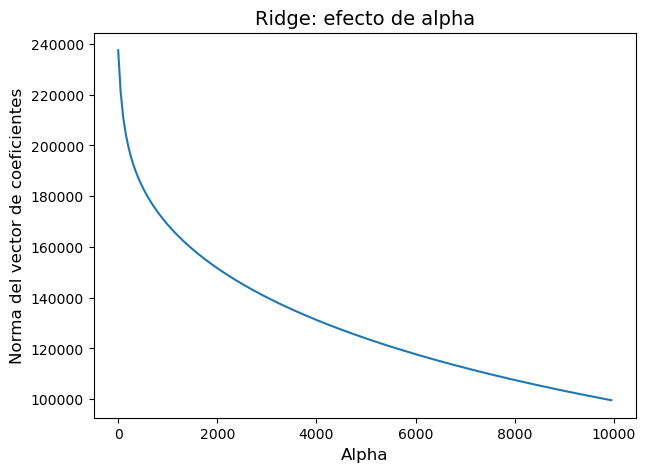

In [29]:
plt.figure(figsize=(7,5))
plt.plot(np.array(norma_coefs)[0:,0],np.array(norma_coefs)[0:,1])
plt.title('Ridge: efecto de alpha',fontdict=dict(fontsize=14))
plt.xlabel('Alpha', fontdict=dict(fontsize=12))
plt.ylabel('Norma del vector de coeficientes', fontdict=dict(fontsize=12));

A pesar de que la norma se reduce, vemos que los parámetros se mantienen todos, en valor absoluto, mayores a cero: 

In [30]:
rlr.coef_[rlr.coef_==0]

array([], dtype=float64)

#### 2.3) Regresión Lasso

Importemos la clase `Lasso` de `sklearn.linear_model` y entrenemos el modelo aplicando la **regresión Lasso**:

In [31]:
from sklearn.linear_model import Lasso

In [32]:
llr = Lasso(alpha=1000)

llr.fit(X_train_feat_eng, y_train)

y_pred_train_lasso = llr.predict(X_train_feat_eng)
y_pred_test_lasso = llr.predict(X_test_feat_eng)

print ('R2 train Lasso: {}'.format(r2_score(y_train, y_pred_train_lasso).round(4)))
print ('R2 test Lasso: {}'.format(r2_score(y_test,y_pred_test_lasso).round(4)))

R2 train Lasso: 0.7597
R2 test Lasso: 0.7452


Vemos que la regresión Lasso igualó a muchos pesos a cero, efectivamente eliminando del modelo a las variables correspondientes:

In [33]:
print(f"Number of coef equal to zero: {(llr.coef_==0).sum()}")

Number of coef equal to zero: 81


Observamos que a medida que se incrementa $\alpha$ en la regresión Lasso, además de caer la norma del vector de coeficientes, además una proporción cada vez mayor es igualada a cero. 

In [34]:
from operator import truediv

zero_coefs = []

for alpha in range(1,10000,1000):
    model = Lasso(alpha=alpha).fit(X_train_feat_eng, y_train)
    zeros = len(model.coef_[model.coef_==0]) / len(model.coef_)
    zero_coefs.append([alpha,zeros])

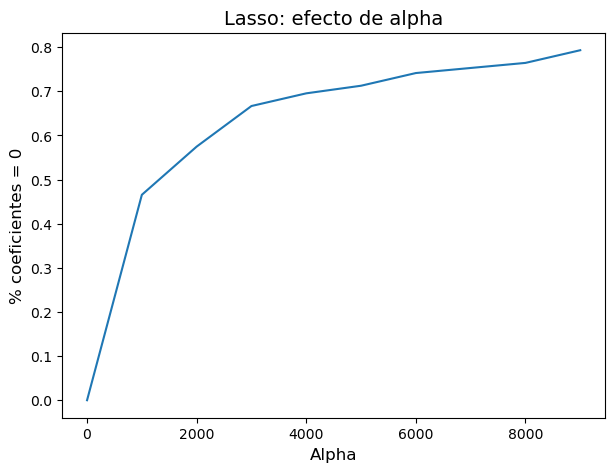

In [35]:
plt.figure(figsize=(7,5))
plt.plot(np.array(zero_coefs)[0:,0],np.array(zero_coefs)[0:,1])
plt.title('Lasso: efecto de alpha',fontdict=dict(fontsize=14))
plt.xlabel('Alpha', fontdict=dict(fontsize=12))
plt.ylabel('% coeficientes = 0', fontdict=dict(fontsize=12));

#### 2.4) ElasticNet

Importemos la clase `ElasticNet` de `sklearn.linear_model` y entrenemos el modelo aplicando la **regresión ElasticNet**:

In [36]:
from sklearn.linear_model import ElasticNet

In [37]:
elr = ElasticNet(alpha=1, l1_ratio=0.5)

elr.fit(X_train_feat_eng, y_train)

y_pred_train_elastic = elr.predict(X_train_feat_eng)
y_pred_test_elastic = elr.predict(X_test_feat_eng)

print ('R2 train ElasticNet: {}'.format(r2_score(y_train, y_pred_train_elastic).round(4)))
print ('R2 test ElasticNet: {}'.format(r2_score(y_test,y_pred_test_elastic).round(4)))

R2 train ElasticNet: 0.7315
R2 test ElasticNet: 0.7277


En el caso de `ElasticNet`, tenemos que definir 2 hiperparámetros. Podemos ingresar a la documentación de la clase para ver de qué manera está implementada la combinación entre `Ridge` y `Lasso` y como ingresan ambos hiperparámetros al modelo. 

`ElasticNet` minimiza la siguiente función objetivo:

        1 / (2 * n_samples) * ||y - Xw||^2_2
        + alpha * l1_ratio * ||w||_1
        + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2

En la clase que viene, veremos técnicas para buscar las combinaciones óptimas de los hiperparámetros.